In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import axes
from matplotlib import font_manager as fm
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
from scipy.stats import gaussian_kde
import oddt
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from oddt.scoring import scorer, ensemble_model
from oddt.utils import method_caller
from oddt.scoring.models.regressors import neuralnetwork
import xgboost as xgb
from sklearn.linear_model import SGDRegressor
from sklearn.inspection import permutation_importance
import shap
from collections import defaultdict
import pandas as pd
import numpy as np
import oddt
from oddt import toolkit
from oddt.scoring.descriptors import close_contacts_descriptor, oddt_vina_descriptor

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

## Figure 2

In [2]:
all_pdb=pd.read_csv("../split_dataset/cluster/pdbbind_2020_cluster_result.csv")
cluster_summary=pd.read_csv("../split_dataset/cluster/PCV_cluster_summary.csv")

In [4]:
labels = cluster_summary[cluster_summary['pdb_num']>300]['cluster'].tolist()
labels.insert(0,"Others")
labels = list(reversed(labels))
sizes = cluster_summary[cluster_summary['pdb_num']>300]['pdb_num'].tolist()
others_num = sum(cluster_summary[cluster_summary['pdb_num']<300]['pdb_num'])
sizes.insert(0, others_num)
sizes = list(reversed(sizes))

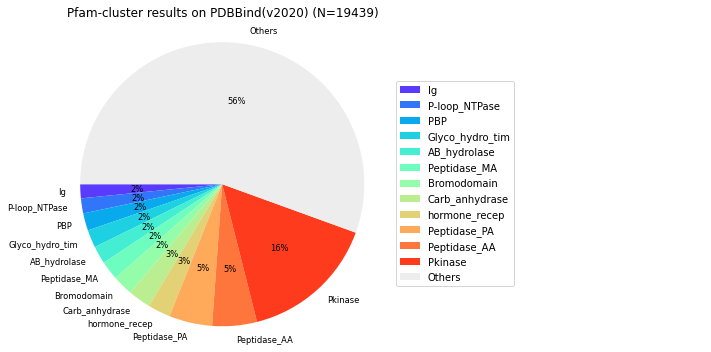

In [5]:
fig, axes = plt.subplots(figsize=(10,5),ncols=2) # 设置绘图区域大小
ax1, ax2 = axes.ravel()

colors = cm.rainbow(np.arange(len(sizes))/len(sizes)) # colormaps: Paired, autumn, rainbow, gray,spring,Darks

grey=np.array([0.75,0.75,0.75,1])
colors=colors[1:]
colors=np.vstack((colors, grey)) 
colors[-1] = [0.93,0.93,0.93,1]
patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=180, colors=colors)
ax1.axis('equal')  

proptease = fm.FontProperties()
proptease.set_size('small')
# font size include: ‘xx-small’,x-small’,'small’,'medium’,‘large’,‘x-large’,‘xx-large’ or number, e.g. '12'
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)

ax1.set_title('Pfam-cluster results on PDBBind(v2020) (N=19439)', loc='center')

# ax2 只显示图例（legend）
ax2.axis('off')
ax2.legend(patches, labels, loc='center left')

plt.tight_layout()
plt.savefig('./png/pfam_cluster_results.png', dpi=800)
# plt.show()

In [8]:
def plot(ax,pd,label):
    ax.set_yticks(range(pd.shape[0]))
    ax.set_yticklabels([])
    ax.set_xticks(range(pd.shape[0]))
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    im = ax.imshow(pd, cmap=cm.get_cmap('viridis'), vmin=0, vmax=1)
    plt.colorbar(im)
    plt.legend('',frameon=False)

In [7]:
protein_dist = pd.read_csv("/pubhome/hzhu02/important_copy/protein_smi_only_main_chain_general_refine_pdbbind_2020.csv")
# lig_smi = pd.read_csv("/pubhome/hzhu02/Redocked_pose/split_dataset/3_fold_ccv/ligand_similarity_pdbbind_2020.csv")
protein_dist.drop(columns=['Unnamed: 0'], inplace=True)
pdb_col= protein_dist.columns.tolist()
protein_dist['pdb'] = pdb_col

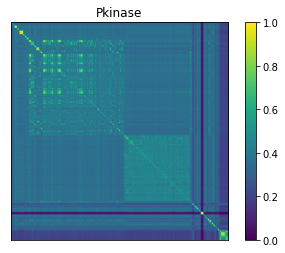

In [10]:
my_pkinase = all_pdb[all_pdb['PCV_cluster']=="pkinase"].sort_values(by=['SCV_cluster','pfam','clan_id'])
pkinase = my_pkinase[['pdb']]
pkinase_matricx = pd.merge(pkinase, protein_dist)
pkinase_matricx_partial = pkinase_matricx.iloc[:,1:]
pkinase_matricx_partial = pkinase_matricx_partial[pkinase_matricx['pdb'].tolist()]
ax1= plt.subplot()
plot(ax1, 1-pkinase_matricx_partial , "Pkinase")
# ax.axhline(y=414, linewidth=2, color="black")
# ax.axvline(x=414, linewidth=2, color="black")
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/pkinase.png",dpi=800)

## Figure 3

In [51]:
all_model_average_result = pd.read_csv("../models/results/all_model_3_fold_average.csv")

In [53]:
rank_power=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/spearman/all_spearman.csv")

In [55]:
rank_power[(rank_power['model']=="SIGN")&(rank_power['CV']=="Random-CV")]['weighted_spearman'].median()

0.5813117629418769

In [56]:
median_label=[]
for model in ['SIGN','OnionNet','RF-Score','SG-CNN','IGN','XGB::VR1','GraphBAR','NNScore','Pafnucy','LR::VR1','LR::V']:
    median_score = rank_power[(rank_power['model']==model)&(rank_power['CV']=="Random-CV")]['weighted_spearman'].median()
    median_label.append([model,median_score])

In [57]:
median_label=pd.DataFrame(median_label, columns=['model','median_spearman'])

In [60]:
spearman_sort = median_label.sort_values(by=['median_spearman'], ascending=False)['model'].to_list()

In [62]:
rank_power.head()

,i,weighted_spearman,model,CV
0,1,0.365935,OnionNet,Seq-CV
1,1,0.557414,OnionNet,Random-CV
2,1,0.384031,OnionNet,Pfam-CV
3,2,0.381976,OnionNet,Seq-CV
4,2,0.556134,OnionNet,Random-CV


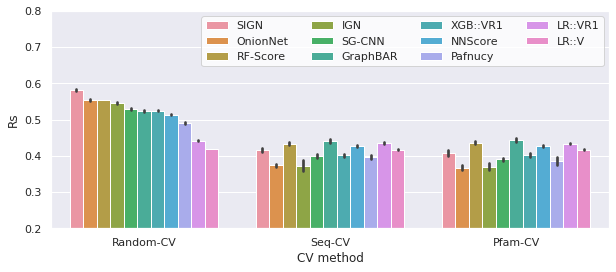

In [66]:
sns.set(font_scale = 1.0)
fig, ax1= plt.subplots(1,1,figsize=(10, 4))
ax1.set_ylim(0.2,0.8)
sns.set_theme(style="whitegrid")
ax1=sns.barplot(x="CV", y="weighted_spearman", hue="model", data=rank_power, hue_order = spearman_sort, order=['Random-CV', 'Seq-CV', 'Pfam-CV'])
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2)
# plt.legend()
plt.legend(loc='upper right', ncol=4)
ax1.set_xlabel("CV method")
ax1.set_ylabel("Rs")
plt.savefig("./png/overall_rs.png", dpi=800, bbox_inches='tight')

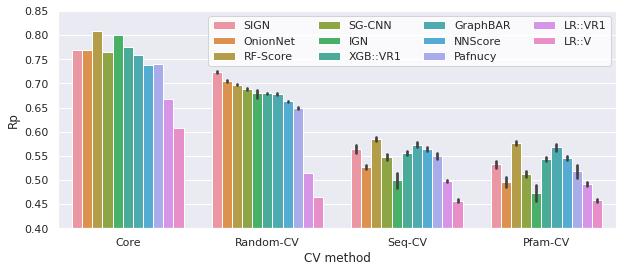

In [30]:
sns.set(font_scale = 1.0)
fig, ax1= plt.subplots(1,1,figsize=(10, 4))
ax1.set_ylim(0.4,0.85)
sns.set_theme(style="whitegrid")
ax1=sns.barplot(x="type", y="average_pearsonr", hue="model", data=all_model_average_result, hue_order = ['SIGN','OnionNet','RF-Score','SG-CNN','IGN','XGB::VR1','GraphBAR','NNScore','Pafnucy','LR::VR1','LR::V'], order=['Core','Random-CV', 'Seq-CV', 'Pfam-CV'])
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2)
# plt.legend()
plt.legend(loc='upper right', ncol=4)
ax1.set_xlabel("CV method")
ax1.set_ylabel("Rp")
plt.savefig("./png/overall_rp.png", dpi=800, bbox_inches='tight')

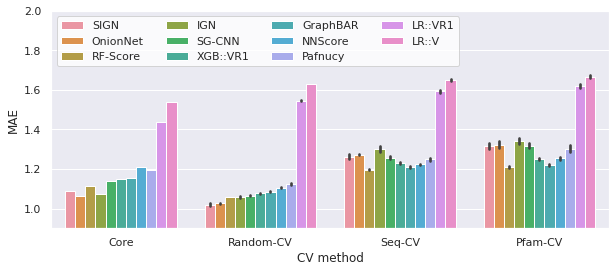

In [31]:
sns.set(font_scale = 1.0)
fig, ax1= plt.subplots(1,1,figsize=(10, 4))
# ax1.set_ylim(0.4,0.85)
ax1.set_ylim(0.9,2.0)
sns.set_theme(style="whitegrid")
ax1=sns.barplot(x="type", y="average_mae", hue="model", data=all_model_average_result, hue_order = ['SIGN','OnionNet','RF-Score','IGN','SG-CNN','XGB::VR1','GraphBAR','NNScore','Pafnucy','LR::VR1','LR::V'], order=['Core','Random-CV', 'Seq-CV', 'Pfam-CV'])
# plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2)
# plt.legend()
plt.legend(loc='upper left', ncol=4)
# plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2)
ax1.set_xlabel("CV method")
ax1.set_ylabel("MAE")
plt.savefig("./png/overall_mae.png", dpi=800, bbox_inches='tight')

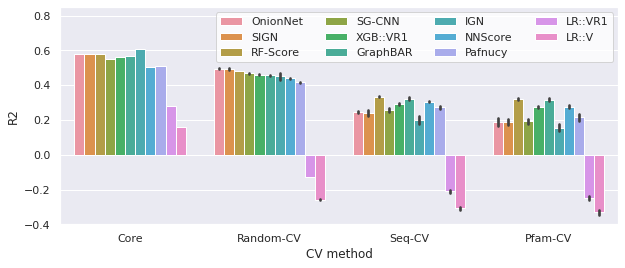

In [32]:
sns.set(font_scale = 1.0)
fig, ax1= plt.subplots(1,1,figsize=(10, 4))
# ax1.set_ylim(0.4,0.85)
ax1.set_ylim(-0.4,0.85)
sns.set_theme(style="whitegrid")
ax1=sns.barplot(x="type", y="average_r2", hue="model", data=all_model_average_result, hue_order = ['OnionNet','SIGN','RF-Score','SG-CNN','XGB::VR1','GraphBAR','IGN','NNScore','Pafnucy','LR::VR1','LR::V'], order=['Core','Random-CV', 'Seq-CV', 'Pfam-CV'])
# plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2)
# plt.legend()
plt.legend(loc='upper right', ncol=4)
# plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2)
ax1.set_xlabel("CV method")
ax1.set_ylabel("R2")
plt.savefig("./png/overall_r2.png", dpi=800, bbox_inches='tight')

## Figure 4
origin scripts:/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/train_test_ligand_similarity.ipynb

In [4]:
selected_cluster=['Alk_phosphatase','Cyclophil-like','POLO_box','Calcineurin','S5']

In [4]:
PCV_clu_score_10 = pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/RFScore_PCV_10_cluster_rp.csv")
rf_PCV_all_pdb_score=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/RFScore_PCV_10_all_pdb_score.csv")
RCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/RFScore_RCV_10_cluster_rp.csv")
rf_RCV_all_pdb_score=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/RFScore_RCV_10_all_pdb_score.csv")

In [6]:
models =["model_"+str(i) for i in range(1,11)]
PCV_clu_score_10['max'] = PCV_clu_score_10[['cluster']+models].max(axis=1)
PCV_clu_score_10['min'] = PCV_clu_score_10[['cluster']+models].min(axis=1)
PCV_clu_score_10['mean'] = PCV_clu_score_10[['cluster']+models].mean(axis=1)
PCV_clu_score_10['std'] = PCV_clu_score_10[['cluster']+models].std(axis=1)
PCV_clu_score_10['mean_plus_std'] = PCV_clu_score_10['mean']+PCV_clu_score_10['std']
PCV_clu_score_10['mean_minus_std'] = PCV_clu_score_10['mean']-PCV_clu_score_10['std']
# models =["model_"+str(i) for i in range(1,11)]
RCV_clu_score_10['max'] = RCV_clu_score_10[['cluster']+models].max(axis=1)
RCV_clu_score_10['min'] = RCV_clu_score_10[['cluster']+models].min(axis=1)
RCV_clu_score_10['mean'] = RCV_clu_score_10[['cluster']+models].mean(axis=1)
RCV_clu_score_10['std'] = RCV_clu_score_10[['cluster']+models].std(axis=1)
RCV_clu_score_10['mean_plus_std'] = RCV_clu_score_10['mean']+RCV_clu_score_10['std']
RCV_clu_score_10['mean_minus_std'] = RCV_clu_score_10['mean']-RCV_clu_score_10['std']

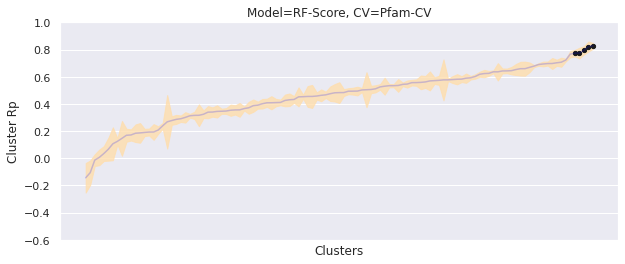

In [13]:
# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(PCV_clu_score_10.sort_values(by=['mean'])['cluster'], PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], PCV_clu_score_10.sort_values(by=['cluster'])['min'], PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(PCV_clu_score_10.sort_values(by=['mean'])['cluster'], PCV_clu_score_10.sort_values(by=['mean'])['mean_minus_std'], PCV_clu_score_10.sort_values(by=['mean'])['mean_plus_std'], color="#FFDEAD", alpha=0.8)
for clu in selected_cluster:
    ax.scatter(PCV_clu_score_10[PCV_clu_score_10['cluster']==clu]['cluster'], PCV_clu_score_10[PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp")
ax.set_ylim(-0.6,1.0)
ax.set_title("Model=RF-Score, CV=Pfam-CV")
# plt.show()
plt.savefig("./png/figure_4_rfscore_pcv.png", dpi=800, bbox_inches='tight')


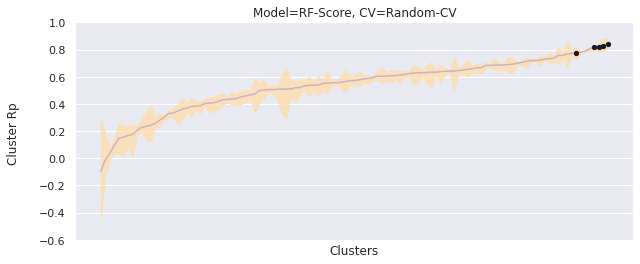

In [12]:
# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(RCV_clu_score_10.sort_values(by=['mean'])['cluster'], RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], RCV_clu_score_10.sort_values(by=['cluster'])['min'], RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(RCV_clu_score_10.sort_values(by=['mean'])['cluster'], RCV_clu_score_10.sort_values(by=['mean'])['min'], RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
for clu in selected_cluster:
    ax.scatter(RCV_clu_score_10[RCV_clu_score_10['cluster']==clu]['cluster'], RCV_clu_score_10[RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp \n")
ax.set_ylim(-0.6,1.0)
ax.set_title("Model=RF-Score, CV=Random-CV")
# plt.show()
plt.savefig("./png/figure_4_rfscore_rcv.png", dpi=800, bbox_inches='tight')


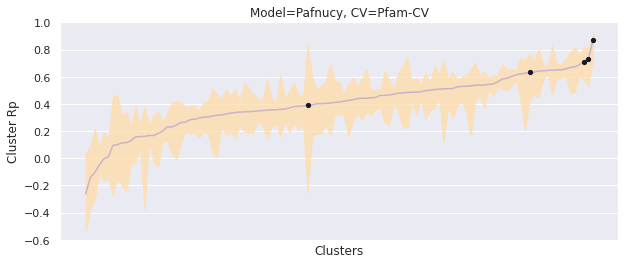

In [11]:
pafnucy_PCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/pafnucy_pcv_10_cluster_rp.csv")
pafnucy_RCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/pafnucy_rcv_10_cluster_rp.csv")

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(pafnucy_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], pafnucy_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(pafnucy_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], pafnucy_PCV_clu_score_10.sort_values(by=['mean'])['mean'],color="#0000FF", alpha=0.2)
# ax.fill_between(pafnucy_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], pafnucy_PCV_clu_score_10.sort_values(by=['cluster'])['min'], pafnucy_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(pafnucy_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], pafnucy_PCV_clu_score_10.sort_values(by=['mean'])['min'], pafnucy_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
for clu in selected_cluster:
    ax.scatter(clu, pafnucy_PCV_clu_score_10[pafnucy_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp")
ax.set_ylim(-0.6,1.0)
ax.set_title("Model=Pafnucy, CV=Pfam-CV")
# plt.show()
plt.savefig("./png/figure_4_pafnucy_pcv.png", dpi=800, bbox_inches='tight')


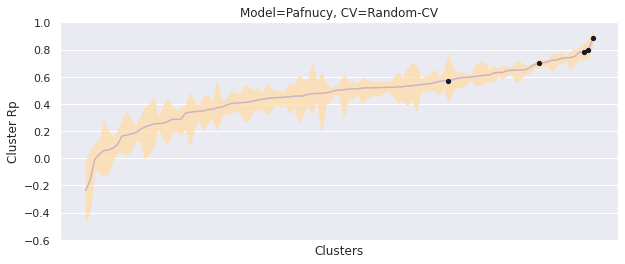

In [14]:
# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(pafnucy_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], pafnucy_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(pafnucy_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], pafnucy_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(pafnucy_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], pafnucy_RCV_clu_score_10.sort_values(by=['cluster'])['min'], pafnucy_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(pafnucy_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], pafnucy_RCV_clu_score_10.sort_values(by=['mean'])['min'], pafnucy_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
for clu in selected_cluster:
    ax.scatter(clu, pafnucy_RCV_clu_score_10[pafnucy_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp")
ax.set_ylim(-0.6,1.0)
ax.set_title("Model=Pafnucy, CV=Random-CV")
# plt.show()
plt.savefig("./png/figure_4_pafnucy_rcv.png", dpi=800, bbox_inches='tight')


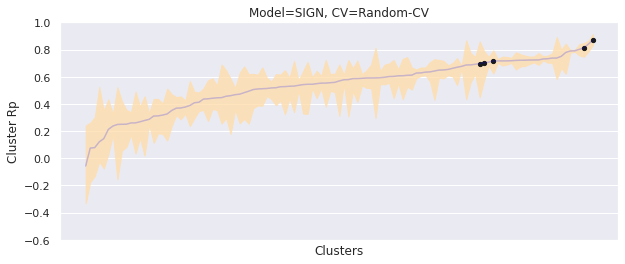

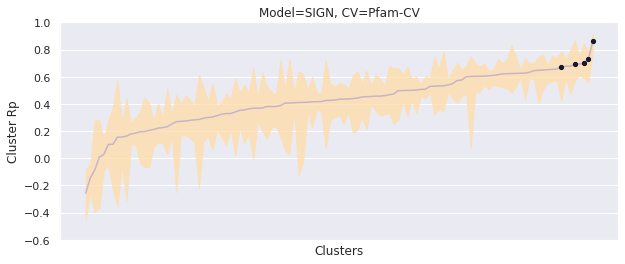

In [16]:
sign_PCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/sign_PCV_clu_score_10.csv")
sign_RCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/sign_RCV_clu_score_10.csv")

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(sign_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], sign_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(sign_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], sign_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(sign_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], sign_RCV_clu_score_10.sort_values(by=['cluster'])['min'], sign_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(sign_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], sign_RCV_clu_score_10.sort_values(by=['mean'])['min'], sign_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylim(-0.6,1.0)
ax.set_ylabel("Cluster Rp")
ax.set_title("Model=SIGN, CV=Random-CV")
for clu in selected_cluster:
    ax.scatter(clu, sign_RCV_clu_score_10[sign_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_sign_rcv.png", dpi=800, bbox_inches='tight')

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(sign_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], sign_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(sign_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], sign_PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(sign_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], sign_PCV_clu_score_10.sort_values(by=['cluster'])['min'], sign_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(sign_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], sign_PCV_clu_score_10.sort_values(by=['mean'])['min'], sign_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp")
ax.set_ylim(-0.6,1.0)
ax.set_title("Model=SIGN, CV=Pfam-CV")
for clu in selected_cluster:
    ax.scatter(clu, sign_PCV_clu_score_10[sign_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_sign_pcv.png", dpi=800, bbox_inches='tight')


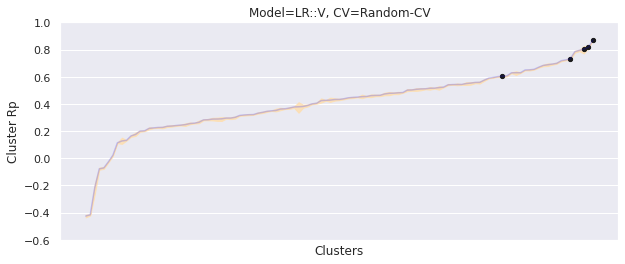

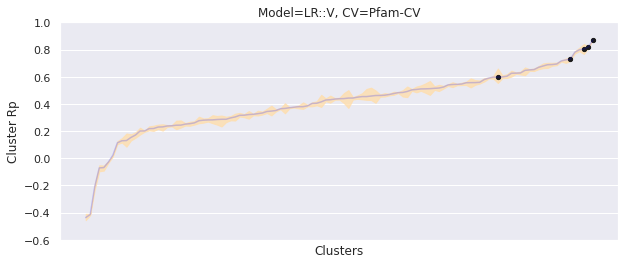

In [17]:
LR_V_PCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/LR_V_PCV_10_cluster_rp.csv")
LR_V_RCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/LR_V_RCV_10_cluster_rp.csv")


# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(LR_V_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], LR_V_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(LR_V_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], LR_V_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(LR_V_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], LR_V_RCV_clu_score_10.sort_values(by=['cluster'])['min'], LR_V_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(LR_V_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], LR_V_RCV_clu_score_10.sort_values(by=['mean'])['min'], LR_V_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylim(-0.6,1.0)
ax.set_ylabel("Cluster Rp")
ax.set_title("Model=LR::V, CV=Random-CV")
for clu in selected_cluster:
    ax.scatter(clu, LR_V_RCV_clu_score_10[LR_V_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_LR_V_rcv.png", dpi=800, bbox_inches='tight')

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(LR_V_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], LR_V_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(LR_V_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], LR_V_PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(LR_V_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], LR_V_PCV_clu_score_10.sort_values(by=['cluster'])['min'], LR_V_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(LR_V_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], LR_V_PCV_clu_score_10.sort_values(by=['mean'])['min'], LR_V_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp")
ax.set_ylim(-0.6,1.0)
ax.set_title("Model=LR::V, CV=Pfam-CV")
for clu in selected_cluster:
    ax.scatter(clu, LR_V_PCV_clu_score_10[LR_V_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_LR_V_pcv.png", dpi=800, bbox_inches='tight')


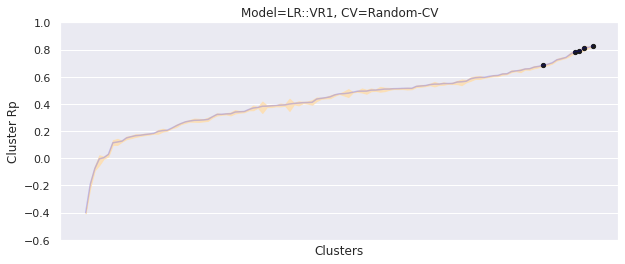

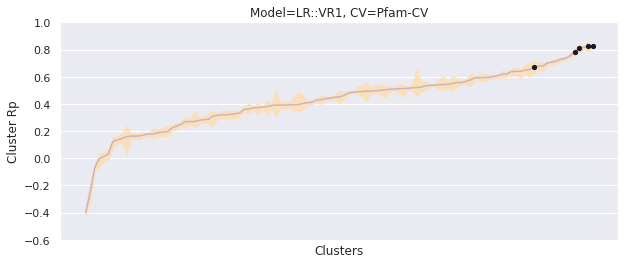

In [18]:
LR_VR1_PCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/LR_VR1_PCV_10_cluster_rp.csv")
LR_VR1_RCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/LR_VR1_RCV_10_cluster_rp.csv")


# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(LR_VR1_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], LR_VR1_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(LR_VR1_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], LR_VR1_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(LR_VR1_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], LR_VR1_RCV_clu_score_10.sort_values(by=['cluster'])['min'], LR_VR1_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(LR_VR1_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], LR_VR1_RCV_clu_score_10.sort_values(by=['mean'])['min'], LR_VR1_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp")
ax.set_ylim(-0.6,1.0)
ax.set_title("Model=LR::VR1, CV=Random-CV")
for clu in selected_cluster:
    ax.scatter(clu, LR_VR1_RCV_clu_score_10[LR_VR1_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_LR_VR1_rcv.png", dpi=800, bbox_inches='tight')

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(LR_VR1_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], LR_VR1_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(LR_VR1_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], LR_VR1_PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(LR_VR1_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], LR_VR1_PCV_clu_score_10.sort_values(by=['cluster'])['min'], LR_VR1_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(LR_VR1_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], LR_VR1_PCV_clu_score_10.sort_values(by=['mean'])['min'], LR_VR1_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp")
ax.set_ylim(-0.6,1.0)
ax.set_title("Model=LR::VR1, CV=Pfam-CV")
for clu in selected_cluster:
    ax.scatter(clu, LR_VR1_PCV_clu_score_10[LR_VR1_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_LR_VR1_pcv.png", dpi=800, bbox_inches='tight')


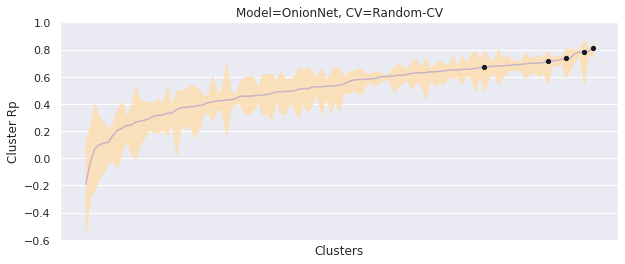

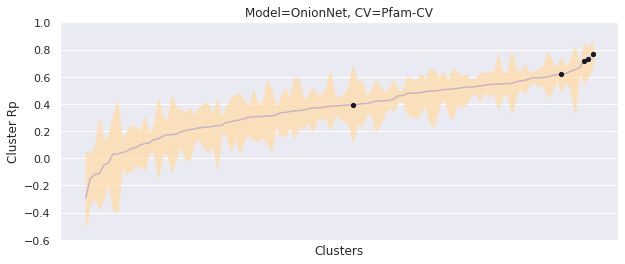

In [19]:
OnionNet_PCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/onion_PCV_clu_score_10.csv")
OnionNet_RCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/onion_RCV_clu_score_10.csv")


# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(OnionNet_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], OnionNet_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(OnionNet_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], OnionNet_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(OnionNet_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], OnionNet_RCV_clu_score_10.sort_values(by=['cluster'])['min'], OnionNet_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(OnionNet_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], OnionNet_RCV_clu_score_10.sort_values(by=['mean'])['min'], OnionNet_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylim(-0.6,1.0)
ax.set_ylabel("Cluster Rp")
ax.set_title("Model=OnionNet, CV=Random-CV")
for clu in selected_cluster:
    ax.scatter(clu, OnionNet_RCV_clu_score_10[OnionNet_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_OnionNet_rcv.png", dpi=800, bbox_inches='tight')

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(OnionNet_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], OnionNet_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(OnionNet_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], OnionNet_PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(OnionNet_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], OnionNet_PCV_clu_score_10.sort_values(by=['cluster'])['min'], OnionNet_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(OnionNet_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], OnionNet_PCV_clu_score_10.sort_values(by=['mean'])['min'], OnionNet_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp")
ax.set_ylim(-0.6,1.0)
ax.set_title("Model=OnionNet, CV=Pfam-CV")
for clu in selected_cluster:
    ax.scatter(clu, OnionNet_PCV_clu_score_10[OnionNet_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_OnionNet_pcv.png", dpi=800, bbox_inches='tight')


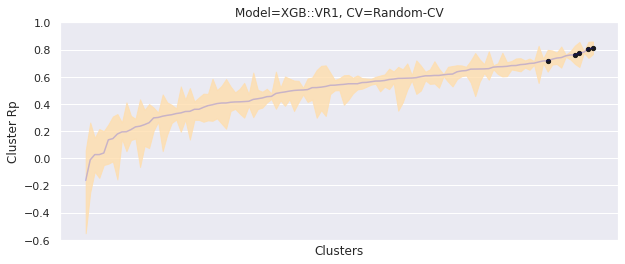

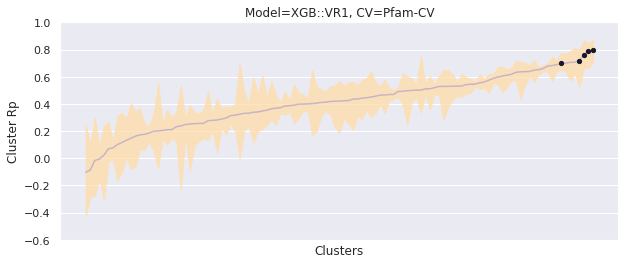

In [5]:
XGB_VR1_PCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/XGB_PCV_10_cluster_rp.csv")
XGB_VR1_RCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/XGB_RCV_10_cluster_rp.csv")


# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(XGB_VR1_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], XGB_VR1_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(XGB_VR1_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], XGB_VR1_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(XGB_VR1_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], XGB_VR1_RCV_clu_score_10.sort_values(by=['cluster'])['min'], XGB_VR1_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(XGB_VR1_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], XGB_VR1_RCV_clu_score_10.sort_values(by=['mean'])['min'], XGB_VR1_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylim(-0.6,1.0)
ax.set_ylabel("Cluster Rp")
ax.set_title("Model=XGB::VR1, CV=Random-CV")
for clu in selected_cluster:
    ax.scatter(clu, XGB_VR1_RCV_clu_score_10[XGB_VR1_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_XGB_VR1_rcv.png", dpi=800, bbox_inches='tight')

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(XGB_VR1_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], XGB_VR1_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(XGB_VR1_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], XGB_VR1_PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(XGB_VR1_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], XGB_VR1_PCV_clu_score_10.sort_values(by=['cluster'])['min'], XGB_VR1_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(XGB_VR1_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], XGB_VR1_PCV_clu_score_10.sort_values(by=['mean'])['min'], XGB_VR1_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylim(-0.6,1.0)
ax.set_ylabel("Cluster Rp")
ax.set_title("Model=XGB::VR1, CV=Pfam-CV")
for clu in selected_cluster:
    ax.scatter(clu, XGB_VR1_PCV_clu_score_10[XGB_VR1_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_XGB_VR1_pcv.png", dpi=800, bbox_inches='tight')


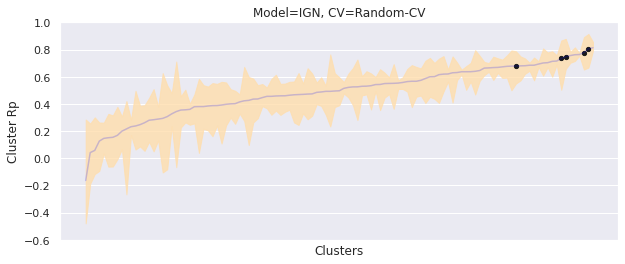

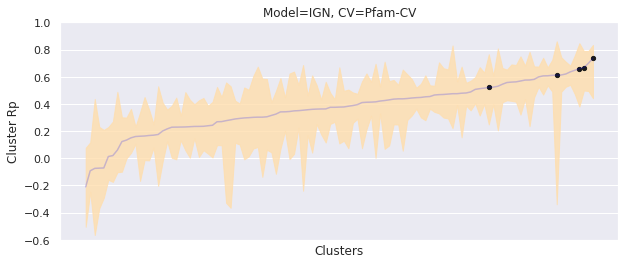

In [21]:
IGN_PCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/ign_PCV_clu_score_10.csv")
IGN_RCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/ign_RCV_clu_score_10.csv")


# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(IGN_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], IGN_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(IGN_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], IGN_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(IGN_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], IGN_RCV_clu_score_10.sort_values(by=['cluster'])['min'], IGN_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(IGN_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], IGN_RCV_clu_score_10.sort_values(by=['mean'])['min'], IGN_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp")
ax.set_ylim(-0.6,1.0)
ax.set_title("Model=IGN, CV=Random-CV")
for clu in selected_cluster:
    ax.scatter(clu, IGN_RCV_clu_score_10[IGN_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_IGN_rcv.png", dpi=800, bbox_inches='tight')

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(IGN_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], IGN_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(IGN_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], IGN_PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(IGN_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], IGN_PCV_clu_score_10.sort_values(by=['cluster'])['min'], IGN_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(IGN_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], IGN_PCV_clu_score_10.sort_values(by=['mean'])['min'], IGN_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylim(-0.6,1.0)
ax.set_ylabel("Cluster Rp")
ax.set_title("Model=IGN, CV=Pfam-CV")
for clu in selected_cluster:
    ax.scatter(clu, IGN_PCV_clu_score_10[IGN_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_IGN_pcv.png", dpi=800, bbox_inches='tight')


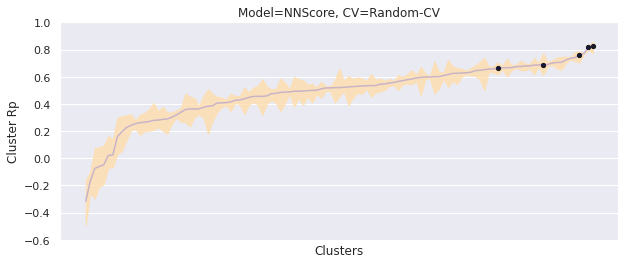

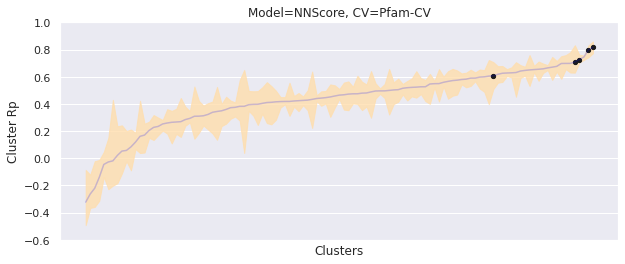

In [22]:
NNScore_PCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/NN_PCV_10_cluster_rp.csv")
NNScore_RCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/NN_RCV_10_cluster_rp.csv")


# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(NNScore_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], NNScore_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(NNScore_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], NNScore_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(NNScore_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], NNScore_RCV_clu_score_10.sort_values(by=['cluster'])['min'], NNScore_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(NNScore_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], NNScore_RCV_clu_score_10.sort_values(by=['mean'])['min'], NNScore_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylim(-0.6,1.0)
ax.set_ylabel("Cluster Rp")
ax.set_title("Model=NNScore, CV=Random-CV")
for clu in selected_cluster:
    ax.scatter(clu, NNScore_RCV_clu_score_10[NNScore_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_NNScore_rcv.png", dpi=800, bbox_inches='tight')

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(NNScore_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], NNScore_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(NNScore_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], NNScore_PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(NNScore_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], NNScore_PCV_clu_score_10.sort_values(by=['cluster'])['min'], NNScore_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(NNScore_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], NNScore_PCV_clu_score_10.sort_values(by=['mean'])['min'], NNScore_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylim(-0.6,1.0)
ax.set_ylabel("Cluster Rp")
ax.set_title("Model=NNScore, CV=Pfam-CV")
for clu in selected_cluster:
    ax.scatter(clu, NNScore_PCV_clu_score_10[NNScore_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_NNScore_pcv.png", dpi=800, bbox_inches='tight')


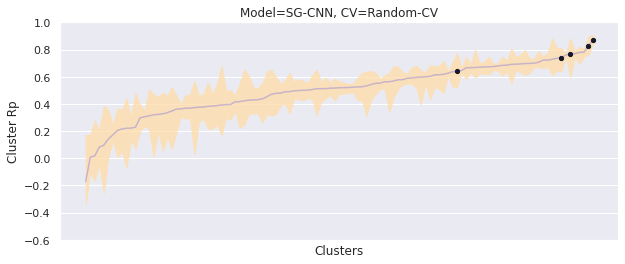

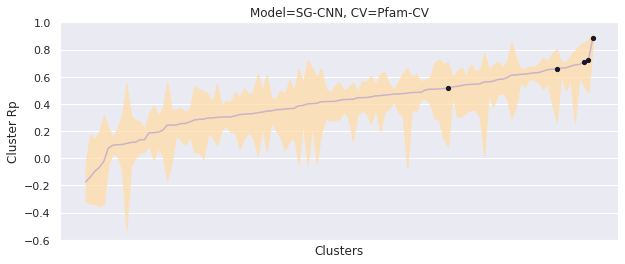

In [23]:
SGCNN_PCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/sgcnn_PCV_clu_score_10.csv")
SGCNN_RCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/sgcnn_RCV_clu_score_10.csv")


# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(SGCNN_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], SGCNN_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(SGCNN_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], SGCNN_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(SGCNN_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], SGCNN_RCV_clu_score_10.sort_values(by=['cluster'])['min'], SGCNN_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(SGCNN_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], SGCNN_RCV_clu_score_10.sort_values(by=['mean'])['min'], SGCNN_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylim(-0.6,1.0)
ax.set_ylabel("Cluster Rp")
ax.set_title("Model=SG-CNN, CV=Random-CV")
for clu in selected_cluster:
    ax.scatter(clu, SGCNN_RCV_clu_score_10[SGCNN_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_SGCNN_rcv.png", dpi=800, bbox_inches='tight')

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(SGCNN_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], SGCNN_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(SGCNN_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], SGCNN_PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(SGCNN_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], SGCNN_PCV_clu_score_10.sort_values(by=['cluster'])['min'], SGCNN_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(SGCNN_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], SGCNN_PCV_clu_score_10.sort_values(by=['mean'])['min'], SGCNN_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylim(-0.6,1.0)
ax.set_ylabel("Cluster Rp")
ax.set_title("Model=SG-CNN, CV=Pfam-CV")
for clu in selected_cluster:
    ax.scatter(clu, SGCNN_PCV_clu_score_10[SGCNN_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_SGCNN_pcv.png", dpi=800, bbox_inches='tight')


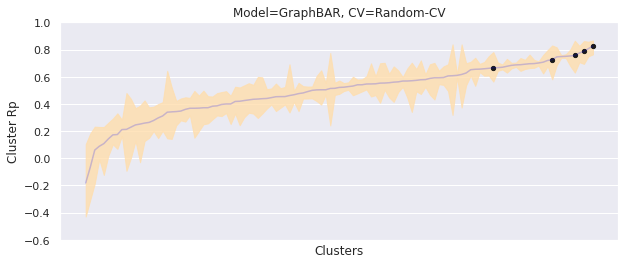

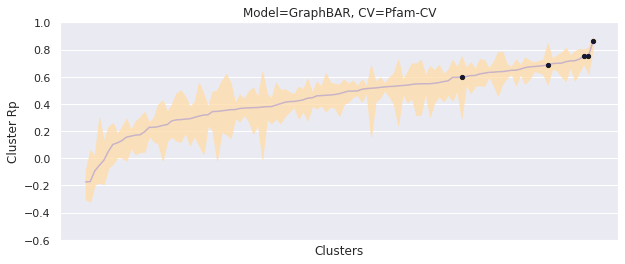

In [24]:
GraphBAR_PCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/graphbar_PCV_clu_score_10.csv")
GraphBAR_RCV_clu_score_10=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/graphbar_RCV_clu_score_10.csv")


# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(GraphBAR_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], GraphBAR_RCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(GraphBAR_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], GraphBAR_RCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(GraphBAR_RCV_clu_score_10.sort_values(by=['cluster'])['cluster'], GraphBAR_RCV_clu_score_10.sort_values(by=['cluster'])['min'], GraphBAR_RCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(GraphBAR_RCV_clu_score_10.sort_values(by=['mean'])['cluster'], GraphBAR_RCV_clu_score_10.sort_values(by=['mean'])['min'], GraphBAR_RCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylim(-0.6,1.0)
ax.set_ylabel("Cluster Rp")
ax.set_title("Model=GraphBAR, CV=Random-CV")
for clu in selected_cluster:
    ax.scatter(clu, GraphBAR_RCV_clu_score_10[GraphBAR_RCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_GraphBAR_rcv.png", dpi=800, bbox_inches='tight')

# plt.figure(figsize=(6, 12), facecolor='w', edgecolor='k')
sns.set(font_scale=1.0)
fig, ax =plt.subplots(figsize=(10,4))
# ax.plot(GraphBAR_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], GraphBAR_PCV_clu_score_10.sort_values(by=['cluster'])['mean'])
ax.plot(GraphBAR_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], GraphBAR_PCV_clu_score_10.sort_values(by=['mean'])['mean'], color="#0000FF", alpha=0.2)
# ax.fill_between(GraphBAR_PCV_clu_score_10.sort_values(by=['cluster'])['cluster'], GraphBAR_PCV_clu_score_10.sort_values(by=['cluster'])['min'], GraphBAR_PCV_clu_score_10.sort_values(by=['cluster'])['max'], color="skyblue", alpha=0.8)
ax.fill_between(GraphBAR_PCV_clu_score_10.sort_values(by=['mean'])['cluster'], GraphBAR_PCV_clu_score_10.sort_values(by=['mean'])['min'], GraphBAR_PCV_clu_score_10.sort_values(by=['mean'])['max'], color="#FFDEAD", alpha=0.8)
ax.set_xlabel("Clusters")
ax.set_xticks([])
ax.set_ylabel("Cluster Rp")
ax.set_ylim(-0.6,1.0)
ax.set_title("Model=GraphBAR, CV=Pfam-CV")
for clu in selected_cluster:
    ax.scatter(clu, GraphBAR_PCV_clu_score_10[GraphBAR_PCV_clu_score_10['cluster']==clu]['mean'], c='k', s=18)
# plt.show()
plt.savefig("./png/figure_4_GraphBAR_pcv.png", dpi=800, bbox_inches='tight')


## Figure 5

In [39]:
pcv_rcv_rp = pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/pcv_rcv_rp_compare_10_times.csv")

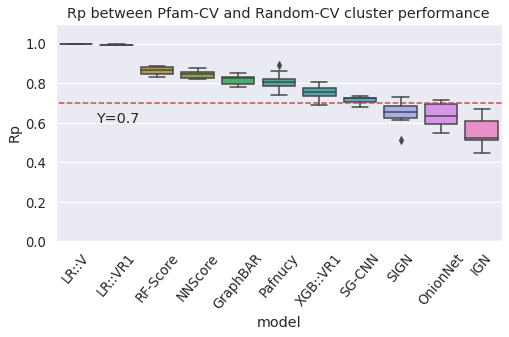

In [41]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(8,4))
plt.hlines(xmin=-1, xmax=13, y=0.7,color="r",linestyles="--", label="y=0.7")
plt.annotate("Y=0.7", (0.5,0.6))
sns.boxplot(data=pcv_rcv_rp, x="model",y="rp", order=['LR::V','LR::VR1','RF-Score','NNScore','GraphBAR','Pafnucy','XGB::VR1','SG-CNN','SIGN','OnionNet','IGN'])
plt.ylim(0,1.1)
plt.title('Rp between Pfam-CV and Random-CV cluster performance')
plt.ylabel('Models')
plt.ylabel("Rp")
for tick in ax.get_xticklabels():
    tick.set_rotation(50)
plt.savefig("./png/figure_5_compare.png", dpi=800, bbox_inches='tight')


In [95]:
RCV_clu_score_10 = RCV_clu_score_10.sort_values(by="cluster")
PCV_clu_score_10 = PCV_clu_score_10.sort_values(by="cluster")

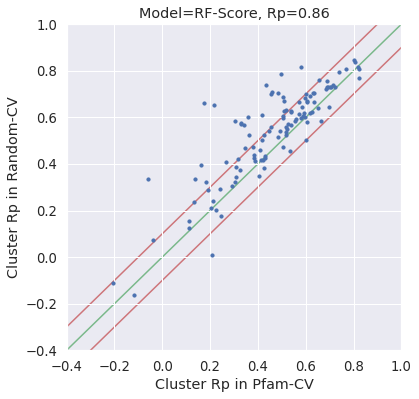

In [107]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(6,6))
plt.xlim(-0.4,1.0)
plt.ylim(-0.4,1.0)
plt.scatter(PCV_clu_score_10['model_1'], RCV_clu_score_10['model_1'],s=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
lims_up=[lim+0.1 for lim in lims]
lims_down =[lim-0.1 for lim in lims]
ax.plot(lims, lims, 'g', alpha=0.75, zorder=0)
ax.plot(lims, lims_up, 'r', alpha=0.75, zorder=0)
ax.plot(lims, lims_down, 'r', alpha=0.75, zorder=0)
plt.xlabel("Cluster Rp in Pfam-CV")
plt.ylabel("Cluster Rp in Random-CV")
plt.title("Model=RF-Score, Rp=0.86")
plt.savefig("./png/figure_5_rfscore.png", dpi=800, bbox_inches='tight')


In [10]:
LR_V_PCV_clu_score_10=LR_V_PCV_clu_score_10.sort_values(by=['cluster'])
LR_V_RCV_clu_score_10=LR_V_RCV_clu_score_10.sort_values(by=['cluster'])

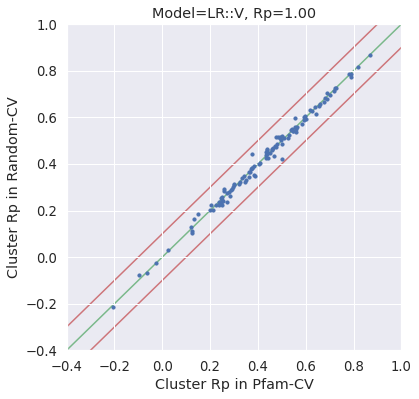

In [11]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(6,6))
plt.xlim(-0.4,1.0)
plt.ylim(-0.4,1.0)
plt.scatter(LR_V_PCV_clu_score_10['model_1'], LR_V_RCV_clu_score_10['model_1'],s=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
lims_up=[lim+0.1 for lim in lims]
lims_down =[lim-0.1 for lim in lims]
ax.plot(lims, lims, 'g', alpha=0.75, zorder=0)
ax.plot(lims, lims_up, 'r', alpha=0.75, zorder=0)
ax.plot(lims, lims_down, 'r', alpha=0.75, zorder=0)
plt.xlabel("Cluster Rp in Pfam-CV")
plt.ylabel("Cluster Rp in Random-CV")
plt.title("Model=LR::V, Rp=1.00")
plt.savefig("./png/figure_5_lr_v.png", dpi=800, bbox_inches='tight')


## Figure 6
/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/RF_feature_importance.ipynb

## Figure 7

In [26]:
sasa_result_pd = pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/sasa_correlation_10_repetition.csv")
model_order=['XGB::VR1','OnionNet','SG-CNN','Pafnucy','IGN','SIGN','GraphBAR','RF-Score','NNScore','LR::VR1','LR::V']

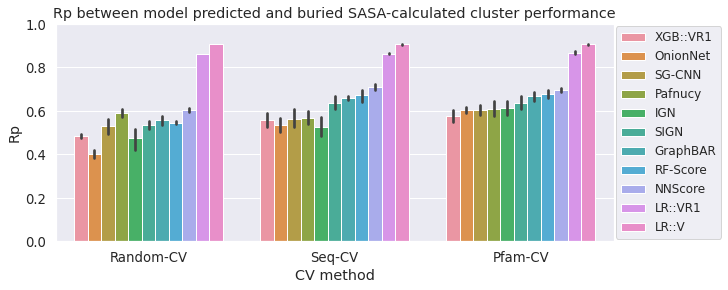

In [43]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(10,4))
sns.barplot(x="cv",y="rp", hue="model", data=sasa_result_pd, order=['Random-CV','Seq-CV','Pfam-CV'], hue_order=model_order)
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1, 1), borderaxespad=0.2, fontsize=12)
# plt.legend()
ax.set_xlabel("CV method")
ax.set_ylabel("Rp")
ax.set_title("Rp between model predicted and buried SASA-calculated cluster performance")
plt.savefig("./png/figure_7_all_model.png", dpi=800, bbox_inches='tight')



In [2]:
single_model=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/eleven_model_cluster_result_selected_cluster.csv")

In [12]:
single_model['pdb_num_new'] = single_model['pdb_num'].apply(lambda x : x if x<200 else 200 )

In [13]:
single_model.head()

,cluster,pdb_num,mw_corre,sasa_corre,rp,mae,r2,model_cv,model,cv,pdb_num_new
0,Acetyltrans,29,0.301535,0.420929,0.274531,1.161390,-0.326500,IGN_RCV,IGN,RCV,29
1,Acetyltrans,29,0.301535,0.420929,0.409308,1.106114,-0.019425,IGN_PCV,IGN,PCV,29
2,Acetyltrans,29,0.301535,0.420929,0.485757,0.940728,0.157210,IGN_SCV,IGN,SCV,29
3,Acetyltrans,29,0.301535,0.420929,0.537913,1.041775,0.089420,LR::VR1_RCV,LR::VR1,RCV,29
4,Acetyltrans,29,0.301535,0.420929,0.541192,0.964109,0.152004,LR::VR1_PCV,LR::VR1,PCV,29


In [16]:
pearsonr(single_model[(single_model['model_cv']=="RFScore_PCV")]['sasa_corre'],single_model[(single_model['model_cv']=="RFScore_PCV")]['rp'])

(0.6618291145152011, 1.453305161463774e-15)

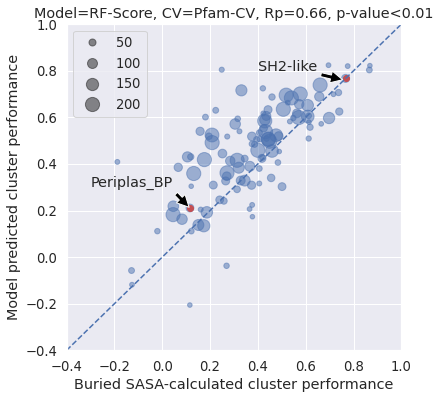

In [18]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(6,6))
plt.xlim(-0.4,1.0)
plt.ylim(-0.4,1.0)
scatter = plt.scatter(x= single_model[(single_model['model_cv']=="RFScore_PCV")]['sasa_corre'], y=single_model[(single_model['model_cv']=="RFScore_PCV")]['rp'], s=single_model[(single_model['model_cv']=="RFScore_PCV")]['pdb_num_new'], alpha=0.5)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, linestyle='dashed')
plt.scatter(single_model[(single_model['cluster']=="Periplas_BP")&(single_model['model_cv']=="RFScore_PCV")]['sasa_corre'], single_model[(single_model['cluster']=="Periplas_BP")&(single_model['model_cv']=="RFScore_PCV")]['rp'], color="r")
plt.scatter(single_model[(single_model['cluster']=="SH2-like")&(single_model['model_cv']=="RFScore_PCV")]['sasa_corre'], single_model[(single_model['cluster']=="SH2-like")&(single_model['model_cv']=="RFScore_PCV")]['rp'], color="r")
plt.annotate("SH2-like", xy = (0.76, 0.76), xytext=(0.4,0.8), arrowprops=dict(facecolor="black", shrink=0.05))
plt.annotate("Periplas_BP", xy = (0.116, 0.21), xytext=(-0.3,0.3), arrowprops=dict(facecolor="black", shrink=0.05))
plt.xlabel("Buried SASA-calculated cluster performance")
plt.ylabel("Model predicted cluster performance")
plt.title("Model=RF-Score, CV=Pfam-CV, Rp=0.66, p-value<0.01")
# plt.legend()
plt.legend(*scatter.legend_elements(prop='sizes', num=4))
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_7_rfscore_pcv_modify.png", dpi=800, bbox_inches='tight')


In [28]:
rfscore_all_pdb_score=pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/RFScore_PCV_10_all_pdb_score.csv")
all_pdb=pd.read_csv("/pubhome/hzhu02/models/Redocked_pose/split_dataset/cluster/pdbbind_2020_cluster_result.csv")
selected_df = pd.merge(rfscore_all_pdb_score[['pdb','pred_model_1']], all_pdb, on=['pdb'])
sh2=selected_df[selected_df['PCV_cluster']=="SH2-like"]
periplas_bp = selected_df[selected_df['PCV_cluster']=="Periplas_BP"]

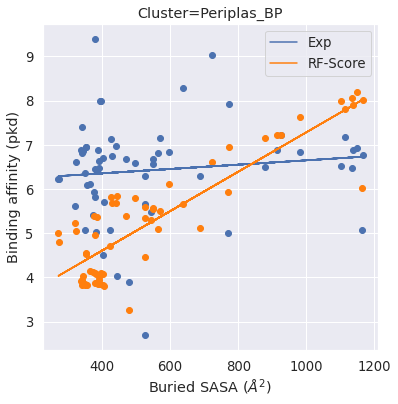

In [29]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(6,6))
x_sasa = periplas_bp[periplas_bp['delta_sasa']>0]['delta_sasa']*100
y_exp = periplas_bp[periplas_bp['delta_sasa']>0]['affinity']
y_pred = periplas_bp[periplas_bp['delta_sasa']>0]['pred_model_1']
z_exp = np.polyfit(x_sasa, y_exp, 1)
p_exp = np.poly1d(z_exp)

z_pred=np.polyfit(x_sasa, y_pred, 1)
p_pred = np.poly1d(z_pred)

plt.scatter(x_sasa,y_exp)
plt.plot(x_sasa,p_exp(x_sasa),c="b", label="Exp")

plt.scatter(x_sasa,y_pred, c="#FF7F0E")
plt.plot(x_sasa,p_pred(x_sasa),c="#FF7F0E", label="RF-Score")
plt.xlabel(r'Buried SASA $  (Å^2) $')
plt.ylabel("Binding affinity (pkd)")
plt.title("Cluster=Periplas_BP")
plt.legend()
# plt.annotate("Exp", xy = (0.76, 0.76), xytext=(8,3), arrowprops=dict(facecolor="black", shrink=0.05))
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_7_periplas_bp.png", dpi=800, bbox_inches='tight')

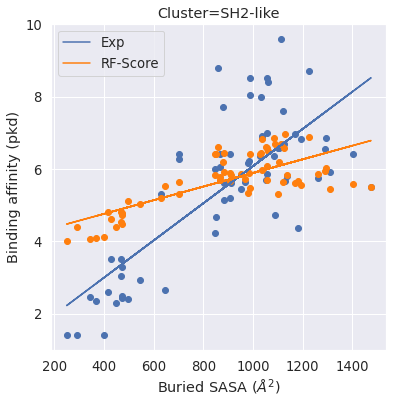

In [30]:
sns.set(font_scale=1.2)
fig, ax =plt.subplots(figsize=(6,6))
x_sasa = sh2[sh2['delta_sasa']>0]['delta_sasa']*100
y_exp = sh2[sh2['delta_sasa']>0]['affinity']
y_pred = sh2[sh2['delta_sasa']>0]['pred_model_1']
z_exp = np.polyfit(x_sasa, y_exp, 1)
p_exp = np.poly1d(z_exp)

z_pred=np.polyfit(x_sasa, y_pred, 1)
p_pred = np.poly1d(z_pred)

plt.scatter(x_sasa,y_exp)
plt.plot(x_sasa,p_exp(x_sasa),c="b", label="Exp")

plt.scatter(x_sasa,y_pred, c="#FF7F0E")
plt.plot(x_sasa,p_pred(x_sasa),c="#FF7F0E", label="RF-Score")
plt.xlabel(r'Buried SASA $  (Å^2) $')
plt.ylabel("Binding affinity (pkd)")
plt.title("Cluster=SH2-like")
plt.legend()
# plt.annotate("Exp", xy = (0.76, 0.76), xytext=(8,3), arrowprops=dict(facecolor="black", shrink=0.05))
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_7_sh2.png", dpi=800, bbox_inches='tight')

In [34]:
features = pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/datasets/descriptors/refine_general_features.csv")
vina_title =['vina_gauss1_x',
            'vina_gauss2_x',
            'vina_repulsion_x',
            'vina_hydrophobic_x',
            'vina_hydrogen_x',
            'vina_num_rotors']
rf_v1_title = features.columns.tolist()[2:38]

feature_list = vina_title+rf_v1_title
all_pdb_feature = pd.merge(all_pdb, features, on=['pdb','affinity'])
all_pdb_feature=all_pdb_feature[(all_pdb_feature['mol_weight']<1000)&(all_pdb_feature['delta_sasa']>0)]

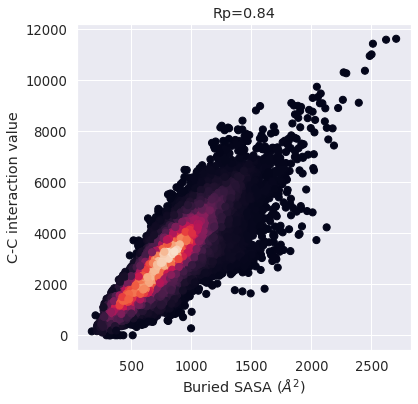

In [35]:
# shap_rotors = [RCV_training_1_shap_values[i][26,26] for i in range(12049)]
plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
x = np.array(all_pdb_feature['delta_sasa']*100, dtype=float)
y = all_pdb_feature['6.6'].to_list()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# fig, ax = plt.subplots(figsize=())
plt.scatter(x, y, c=z, s=50)
# ax.plot(x, x)
plt.xlabel(r'Buried SASA $  (Å^2) $')
plt.ylabel("C-C interaction value")
# plt.savefig(path)
plt.title("Rp=0.84")
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_7_sasa_6_6.png", dpi=800, bbox_inches='tight')
# plt.show()

## Figure 8

In [11]:
pearsonr(all_pdb[(all_pdb['delta_sasa']>0)]['affinity'],all_pdb[(all_pdb['delta_sasa']>0)]['delta_sasa'])

(0.26182346638904896, 1.0321312684668437e-300)

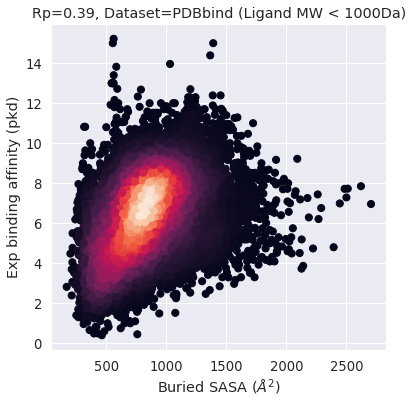

In [36]:
plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
x = np.array(all_pdb_feature['delta_sasa']*100, dtype=float)
y = all_pdb_feature['affinity'].to_list()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# fig, ax = plt.subplots(figsize=())
plt.scatter(x, y, c=z, s=50)
# ax.plot(x, x)
plt.xlabel(r'Buried SASA $  (Å^2) $')
plt.ylabel("Exp binding affinity (pkd)")
# plt.savefig(path)
plt.title("Rp=0.39, Dataset=PDBbind (Ligand MW < 1000Da)")
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_8_sasa_exp_mw_restrain.png", dpi=800, bbox_inches='tight')

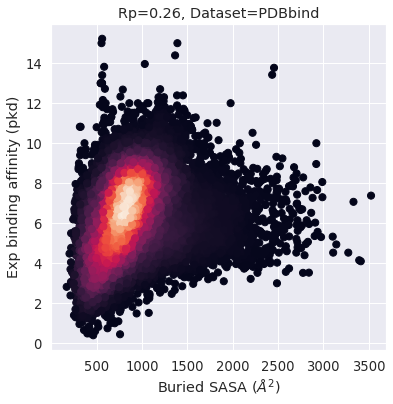

In [37]:
plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
x = np.array(all_pdb[all_pdb['delta_sasa']>0]['delta_sasa']*100, dtype=float)
y = all_pdb[all_pdb['delta_sasa']>0]['affinity'].to_list()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# fig, ax = plt.subplots(figsize=())
plt.scatter(x, y, c=z, s=50)
# ax.plot(x, x)
plt.xlabel(r'Buried SASA $  (Å^2) $')
plt.ylabel("Exp binding affinity (pkd)")
# plt.savefig(path)
plt.title("Rp=0.26, Dataset=PDBbind")
plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_8_sasa_exp_no_mw_restrain.png", dpi=800, bbox_inches='tight')

In [47]:
sasa_cor = pd.read_csv("/pubhome/hzhu02/GPSF/generalization_benchmark/models/general_3_fold_summary/data_mw_bias/eleven_model_cluster_result_selected_cluster.csv")
clean_sasa = sasa_cor[['cluster', 'pdb_num','mw_corre','sasa_corre']].drop_duplicates()


In [50]:
clean_sasa.sort_values(by=['pdb_num'])

,cluster,pdb_num,mw_corre,sasa_corre
126,Calcineurin,21,0.808921,0.868314
360,NTF2,21,0.468438,0.489383
138,POZ,21,0.301108,0.121119
564,una_570,21,0.331023,0.377095
258,TMEM173,21,0.244972,0.115493
...,...,...,...,...
438,hormone_recep,464,0.160519,0.131751
600,Carb_anhydrase,496,0.408682,0.399908
474,Peptidase_PA,894,0.627074,0.660220
174,Peptidase_AA,973,0.449660,0.449653


In [76]:
clean_sasa[clean_sasa['cluster']=="SH2-like"]

,cluster,pdb_num,mw_corre,sasa_corre
150,SH2-like,65,0.779265,0.766625


In [77]:
clean_sasa[clean_sasa['cluster']=="Calcineurin"]

,cluster,pdb_num,mw_corre,sasa_corre
126,Calcineurin,21,0.808921,0.868314


In [78]:
clean_sasa[clean_sasa['cluster']=="Cyclophil-like"]

,cluster,pdb_num,mw_corre,sasa_corre
342,Cyclophil-like,34,0.739676,0.866085


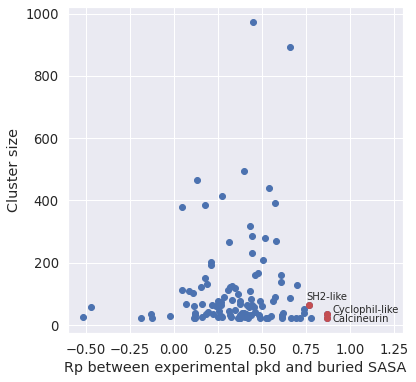

In [85]:

plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
plt.scatter(clean_sasa[clean_sasa['pdb_num']<1000]['sasa_corre'], clean_sasa[clean_sasa['pdb_num']<1000]['pdb_num'])
plt.scatter(clean_sasa[clean_sasa['cluster']=="SH2-like"]['sasa_corre'], clean_sasa[clean_sasa['cluster']=="SH2-like"]['pdb_num'], color="r")
plt.scatter(clean_sasa[clean_sasa['cluster']=="Calcineurin"]['sasa_corre'], clean_sasa[clean_sasa['cluster']=="Calcineurin"]['pdb_num'], color="r")

plt.scatter(clean_sasa[clean_sasa['cluster']=="Cyclophil-like"]['sasa_corre'], clean_sasa[clean_sasa['cluster']=="Cyclophil-like"]['pdb_num'], color="r")

# plt.scatter(clean_sasa[clean_sasa['cluster']=="Avidin"]['sasa_corre'], clean_sasa[clean_sasa['cluster']=="Avidin"]['pdb_num'], color="r")
# plt.scatter(clean_sasa[clean_sasa['cluster']=="Sialidase"]['sasa_corre'], clean_sasa[clean_sasa['cluster']=="Sialidase"]['pdb_num'], color="r")
# plt.scatter(clean_sasa[clean_sasa['cluster']=="Peptidase_AA"]['sasa_corre'], clean_sasa[clean_sasa['cluster']=="Peptidase_AA"]['pdb_num'], color="r")
plt.annotate("SH2-like", xy=(0.75,80), fontsize=10)
plt.annotate("Cyclophil-like", xy=(0.9,40), fontsize=10)
plt.annotate("Calcineurin", xy=(0.9, 10), fontsize=10)
plt.xlim(-0.6,1.3)
plt.xlabel('Rp between experimental pkd and buried SASA')
plt.ylabel('Cluster size')

plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_8_cluster.png", dpi=800, bbox_inches='tight')


In [41]:
all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Calcineurin")]['delta_sasa']*100

2864      410.87036
2865      730.15440
2866      429.93164
5717     1426.82570
5742     1457.30290
6262     1252.29110
6640     1370.24230
8401     1529.81190
8402     1509.10800
9192     1104.24650
9603      713.51547
9604      704.07030
10665     426.45264
11780     766.42456
11792     744.43360
11796     557.35626
11800     575.98877
14893     384.83430
15167    1168.40970
15787     465.28015
18917    1259.39940
Name: delta_sasa, dtype: float64

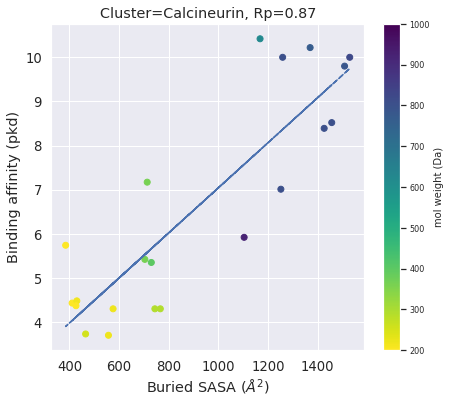

In [44]:

plt.figure(figsize=(7, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
cm = plt.cm.get_cmap('viridis_r')
z_exp = np.polyfit(all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Calcineurin")]['delta_sasa']*100,  all_pdb_feature[all_pdb_feature['PCV_cluster']=="Calcineurin"]['affinity'], 1)
p_exp = np.poly1d(z_exp)
x_sasa=all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Calcineurin")]['delta_sasa']*100
plt.plot(x_sasa ,p_exp(x_sasa),c="b", label="Exp",linestyle="dashed")
# ax.plot(lims, lims, linestyle='dashed')
sc=plt.scatter(all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Calcineurin")]['delta_sasa']*100, all_pdb_feature[all_pdb_feature['PCV_cluster']=="Calcineurin"]['affinity'], c=all_pdb_feature[all_pdb_feature['PCV_cluster']=="Calcineurin"]['mol_weight'], vmin=200, vmax=1000, cmap=cm)
plt.xlabel(r'Buried SASA $  (Å^2) $')
plt.ylabel("Binding affinity (pkd)")
plt.title("Cluster=Calcineurin, Rp=0.87")
# plt.colorbar(sc)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('mol weight (Da)', rotation=-270, fontsize=10)

plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_8_calcineurin.png", dpi=800, bbox_inches='tight')


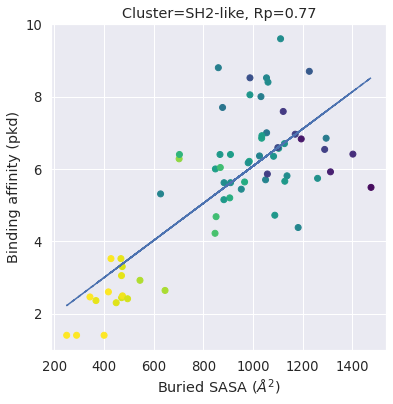

In [45]:

plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
cm = plt.cm.get_cmap('viridis_r')
z_exp = np.polyfit(all_pdb_feature[(all_pdb_feature['PCV_cluster']=="SH2-like")]['delta_sasa']*100,  all_pdb_feature[all_pdb_feature['PCV_cluster']=="SH2-like"]['affinity'], 1)
p_exp = np.poly1d(z_exp)
x_sasa=all_pdb_feature[(all_pdb_feature['PCV_cluster']=="SH2-like")]['delta_sasa']*100
plt.plot(x_sasa,p_exp(x_sasa),c="b", label="Exp",linestyle="dashed")
# ax.plot(lims, lims, linestyle='dashed')
sc=plt.scatter(all_pdb_feature[(all_pdb_feature['PCV_cluster']=="SH2-like")]['delta_sasa']*100, all_pdb_feature[all_pdb_feature['PCV_cluster']=="SH2-like"]['affinity'], c=all_pdb_feature[all_pdb_feature['PCV_cluster']=="SH2-like"]['mol_weight'], vmin=200, vmax=1000, cmap=cm)
plt.xlabel(r'Buried SASA $  (Å^2) $')
plt.ylabel("Binding affinity (pkd)")
plt.title("Cluster=SH2-like, Rp=0.77")
# plt.colorbar(sc)
# cbar = plt.colorbar(sc)
# cbar.ax.tick_params(labelsize=8)
# cbar.set_label('mol weight (Da)', rotation=-270, fontsize=10)

plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_8_SH2-like.png", dpi=800, bbox_inches='tight')


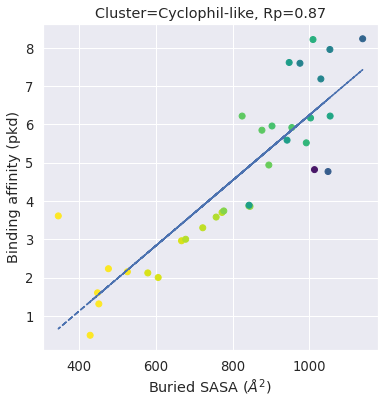

In [46]:

plt.figure(figsize=(6, 6), facecolor='w', edgecolor='k')
sns.set(font_scale=1.2)
cm = plt.cm.get_cmap('viridis_r')
z_exp = np.polyfit(all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Cyclophil-like")]['delta_sasa']*100,  all_pdb_feature[all_pdb_feature['PCV_cluster']=="Cyclophil-like"]['affinity'], 1)
p_exp = np.poly1d(z_exp)
x_sasa=all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Cyclophil-like")]['delta_sasa']*100
plt.plot(x_sasa,p_exp(x_sasa),c="b", label="Exp",linestyle="dashed")
# ax.plot(lims, lims, linestyle='dashed')
sc=plt.scatter(all_pdb_feature[(all_pdb_feature['PCV_cluster']=="Cyclophil-like")]['delta_sasa']*100, all_pdb_feature[all_pdb_feature['PCV_cluster']=="Cyclophil-like"]['affinity'], c=all_pdb_feature[all_pdb_feature['PCV_cluster']=="Cyclophil-like"]['mol_weight'], vmin=200, vmax=1000, cmap=cm)
plt.xlabel(r'Buried SASA $  (Å^2) $')
plt.ylabel("Binding affinity (pkd)")
plt.title("Cluster=Cyclophil-like, Rp=0.87")
# plt.colorbar(sc)
# cbar = plt.colorbar(sc)
# cbar.ax.tick_params(labelsize=8)
# cbar.set_label('mol weight (Da)', rotation=-270, fontsize=10)

plt.savefig("/pubhome/hzhu02/models/Redocked_pose/plot_scripts/png/figure_8_Cyclophil-like.png", dpi=800, bbox_inches='tight')


## OTHERS

In [31]:
check_sasa=pd.read_csv("/pubhome/hzhu02/GPSF/dataset/pdbbind_v2020/general_refine/1swp/tmp/all_atom_sasa.csv")

In [32]:
check_sasa.head()

,pl,c
0,8.2318,8.2318
1,18.3178,18.3178
2,13.5181,13.5181
3,11.8772,11.8772
4,14.2975,14.2975


In [33]:
check_sasa['c'].sum()-check_sasa['pl'].sum()

-553.0383999999976

In [28]:
all_pdb_feature.head()

,pdb,affinity,PCV_cluster,main_chain,res_num,pfam,pfam_name,pdb_start,pdb_end,cov_num,...,as_flex_backbone_other,as_flex_sidechain_alpha,as_flex_sidechain_beta,as_flex_sidechain_other,as_flex_all,salt_bridge_5.5_alpha,salt_bridge_5.5_beta,salt_bridge_5.5_other,salt_bridge_5.5_all,num_rotors
0,4i7p,3.50,Lysozyme,A,39.0,PF00959,Phage_lysozyme,24.0,148.0,37.0,...,0.0,0.0,0.0,28.0,28.0,0.0,0.0,0.0,0.0,0.0
1,1l83,3.40,Lysozyme,A,39.0,PF00959,Phage_lysozyme,24.0,148.0,37.0,...,0.0,0.0,0.0,18.0,18.0,0.0,0.0,0.0,0.0,0.0
2,1li6,3.80,Lysozyme,A,36.0,PF00959,Phage_lysozyme,24.0,148.0,34.0,...,0.0,0.0,0.0,23.0,23.0,0.0,0.0,0.0,0.0,1.0
3,4w52,3.76,Lysozyme,A,38.0,PF00959,Phage_lysozyme,24.0,148.0,36.0,...,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0
4,188l,3.33,Lysozyme,A,42.0,PF00959,Phage_lysozyme,24.0,148.0,40.0,...,0.0,0.0,0.0,17.0,17.0,0.0,0.0,0.0,0.0,2.0


In [29]:
pearsonr(all_pdb_feature['mol_weight'], all_pdb_feature['6.6'])

(0.6299384296645161, 0.0)